In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image
import os


print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


In [ ]:
# Normalizing images

train_datagen = ImageDataGenerator(
    rescale=1./255,             

    rotation_range=25,           
    zoom_range=0.2,              

    width_shift_range=0.1,       
    height_shift_range=0.1,      

    horizontal_flip=True,        

    vertical_flip=False,         

    brightness_range=[0.2, 1.2], 

    shear_range=0.2,             

    fill_mode='nearest'         

   
)




# rescale for validation only
test_val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  
    shuffle=False
)


test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)





Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
# Verifica la forma de las etiquetas
x_batch, y_batch = next(train_generator)
print("Forma de x_batch:", x_batch.shape)
print("Forma de y_batch:", y_batch.shape)
print("Ejemplo de etiqueta:", y_batch[0])


Forma de x_batch: (32, 128, 128, 3)
Forma de y_batch: (32, 3)
Ejemplo de etiqueta: [0. 1. 0.]


In [ ]:
x_val, y_val = next(val_generator)
print("Forma de y_val:", y_val.shape)


Forma de y_val: (32, 3)


Found 1322 images belonging to 3 classes.


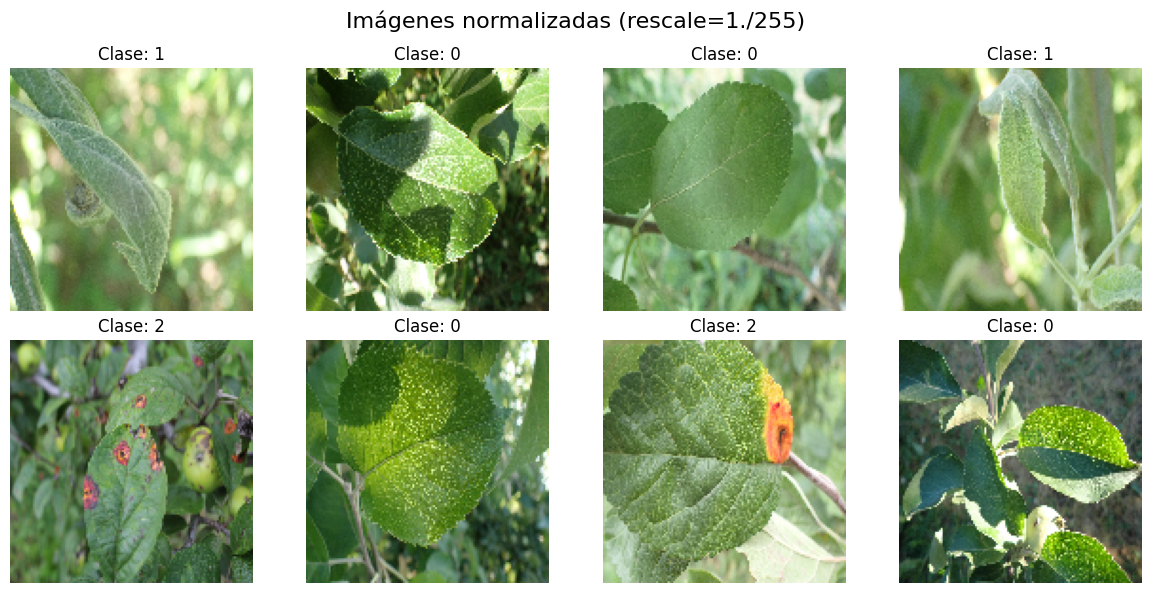

In [ ]:
# ======================
# Visual 1
# ======================

preview_gen = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Train',
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical'
)

images, labels = next(preview_gen)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Clase: {np.argmax(labels[i])}")
    plt.axis('off')
plt.suptitle("Imágenes normalizadas (rescale=1./255)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ======================
# Visual 2: datagen applied
# ======================


def visualizar_augmentaciones_con_original(ruta_imagen, clase_nombre):

    img = image.load_img(ruta_imagen, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    aug_iter = train_datagen.flow(x, batch_size=1)

    plt.figure(figsize=(14, 6))


    plt.subplot(2, 5, 1)
    plt.imshow(x[0].astype(np.uint8))
    plt.title("Original")
    plt.axis('off')


    for i in range(8):
        augmented_image = next(aug_iter)[0].astype(np.float32)
        plt.subplot(2, 5, i + 2)
        plt.imshow(augmented_image)
        plt.title(f"Aug #{i+1}")
        plt.axis('off')

    plt.suptitle(f"Augmentaciones para clase: {clase_nombre}", fontsize=16)
    plt.tight_layout()
    plt.show()



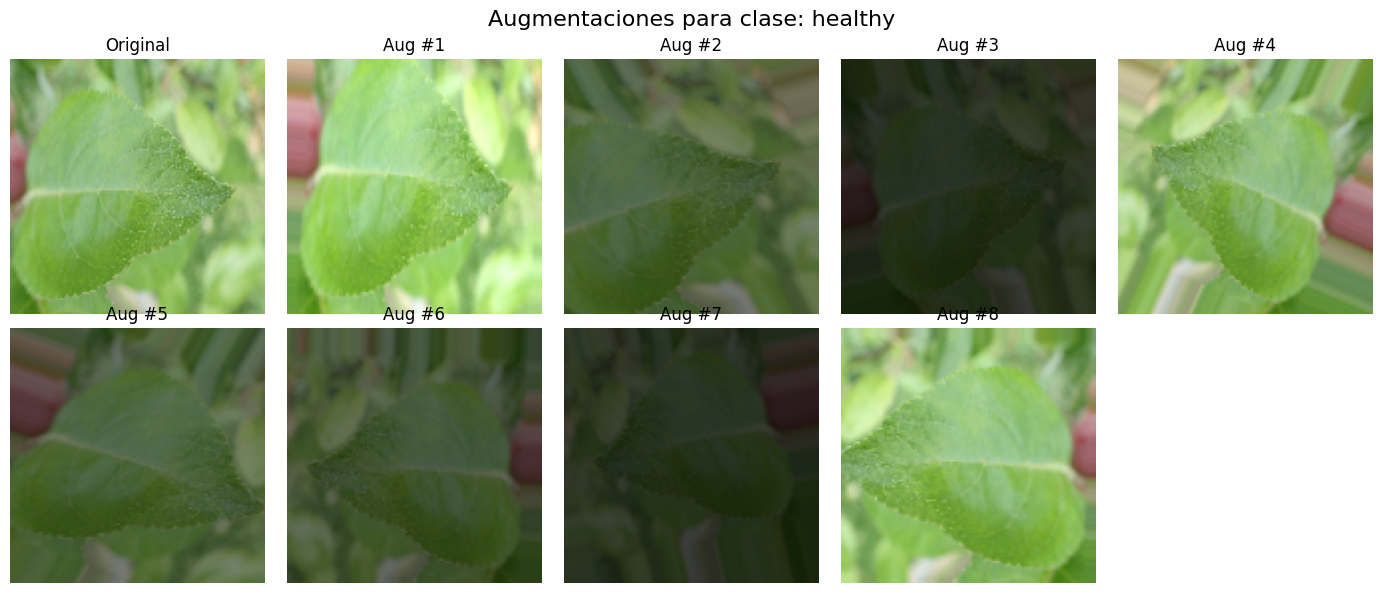

In [ ]:
visualizar_augmentaciones_con_original('/content/drive/MyDrive/Train/Healthy/80c61d6b492d76b7.jpg', 'healthy')

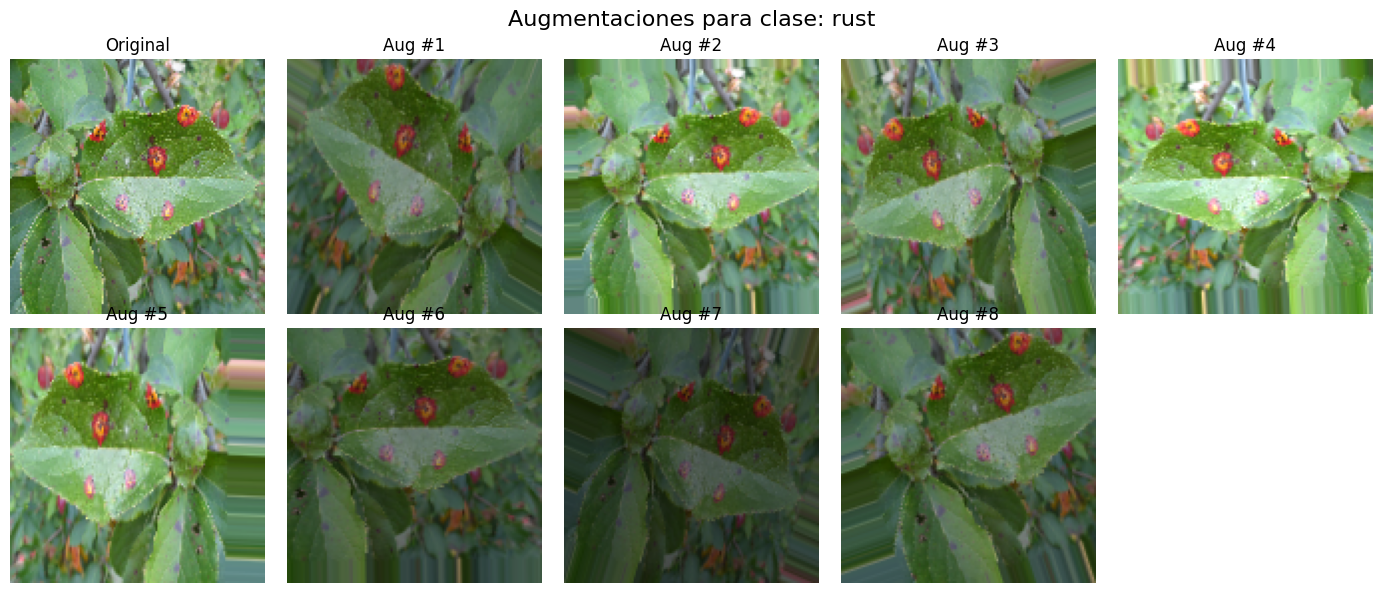

In [ ]:
visualizar_augmentaciones_con_original('/content/drive/MyDrive/Train/Rust/81b4639b9c72790f.jpg', 'rust')

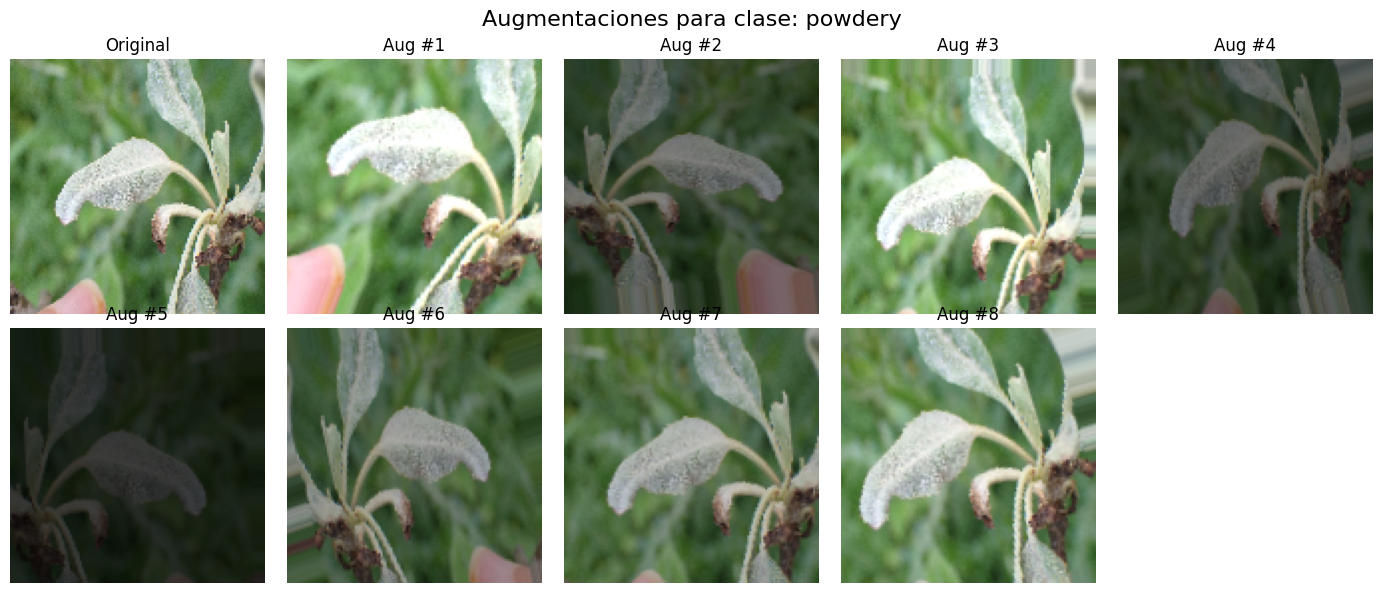

In [ ]:
visualizar_augmentaciones_con_original('/content/drive/MyDrive/Train/Powdery/8299723bc94df5a8.jpg', 'powdery')

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

# model
input_layer = Input(shape=(128, 128, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # 👈 Aquí agregás Dropout
x = layers.Dense(128, activation='relu')(x)
output_layer = layers.Dense(train_generator.num_classes, activation='softmax')(x)


model = models.Model(inputs=input_layer, outputs=output_layer)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


checkpoint_dir = '/content/drive/MyDrive/Model_Checkpoints/'


os.makedirs(checkpoint_dir, exist_ok=True)


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5'),  # Ruta completa al archivo
    monitor='val_loss',  # Monitoriza la métrica 'val_loss'
    save_best_only=True,  # Solo guarda el modelo si mejora el rendimiento
    mode='min',  # 'min' significa que se guardará cuando el valor monitoreado disminuya
    verbose=1  # Muestra el progreso
)

# Entrenamiento y guarda en 'history' (con el callback de checkpoints)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_callback]  # Agregar el callback de checkpoint aquí
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3725 - loss: 1.3636
Epoch 1: val_loss improved from inf to 1.06079, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.3738 - loss: 1.3576 - val_accuracy: 0.4500 - val_loss: 1.0608
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6148 - loss: 0.7930
Epoch 2: val_loss improved from 1.06079 to 0.52457, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.6160 - loss: 0.7912 - val_accuracy: 0.7667 - val_loss: 0.5246
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7211 - loss: 0.6474
Epoch 3: val_loss did not improve from 0.52457
42/42 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7216 - loss: 0.6467 - val_accuracy: 0.7500 - val_loss: 0.5422
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8055 - loss: 0.5142
Epoch 4: val_loss improved from 0.52457 to 0.50177, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8053 - loss: 0.5144 - val_accuracy: 0.7667 - val_loss: 0.5018
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8076 - loss: 0.4879
Epoch 5: val_loss did not improve from 0.50177
42/42 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8081 - loss: 0.4870 - val_accuracy: 0.8500 - val_loss: 0.5509
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8623 - loss: 0.3792
Epoch 6: val_loss did not improve from 0.50177
42/42 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8623 - loss: 0.3793 - val_accuracy: 0.8333 - val_loss: 0.5634
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8769 - loss: 0.3698
Epoch 7: val_loss did not improve from 0.50177
42/42 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.8770 - loss: 0.3690 - val_accuracy: 0.8500 - val_loss: 0.6351
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8657 - loss: 0.3951
Epoch 8: val_loss did not improve from 0.50177
42/42 ━━━━━━━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8781 - loss: 0.3443 - val_accuracy: 0.9000 - val_loss: 0.3685
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8810 - loss: 0.3108
Epoch 10: val_loss improved from 0.36848 to 0.35770, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8815 - loss: 0.3100 - val_accuracy: 0.8833 - val_loss: 0.3577


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# 🔷 Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))



5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step
Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.84      0.92      0.88        50
     Powdery       0.96      0.90      0.93        50
        Rust       0.94      0.90      0.92        50

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


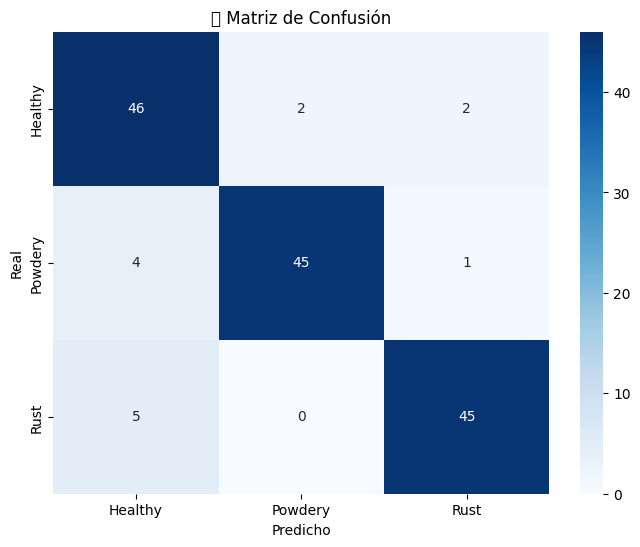

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('🔍 Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


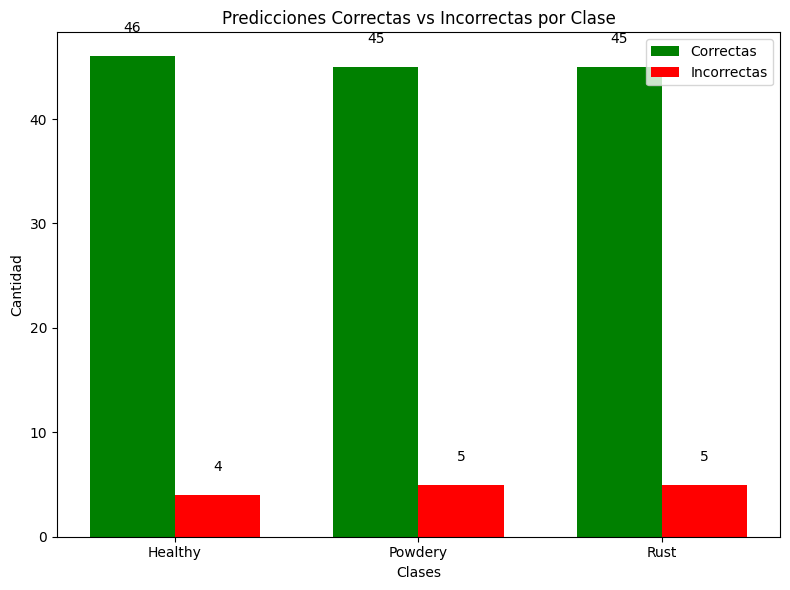

In [ ]:
# Contar las predicciones correctas e incorrectas por clase
correct = np.zeros(len(class_names))
incorrect = np.zeros(len(class_names))

for i in range(len(y_true)):
    if y_pred[i] == y_true[i]:
        correct[y_true[i]] += 1
    else:
        incorrect[y_true[i]] += 1

# Crear un gráfico de barras para las clases predichas vs reales
x = np.arange(len(class_names))  # Ubicaciones de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, correct, width, label='Correctas', color='green')
bars2 = ax.bar(x + width/2, incorrect, width, label='Incorrectas', color='red')

# Añadir etiquetas y título
ax.set_xlabel('Clases')
ax.set_ylabel('Cantidad')
ax.set_title('Predicciones Correctas vs Incorrectas por Clase')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Mostrar las cantidades encima de las barras
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
#training
model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9205 - loss: 0.2412 - val_accuracy: 0.9167 - val_loss: 0.3961
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9049 - loss: 0.2574 - val_accuracy: 0.8333 - val_loss: 0.4003
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8996 - loss: 0.2753 - val_accuracy: 0.9167 - val_loss: 0.3071
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8957 - loss: 0.2894 - val_accuracy: 0.9167 - val_loss: 0.2800
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9094 - loss: 0.2671 - val_accuracy: 0.9000 - val_loss: 0.3697
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9396 - loss: 0.1970 - val_accuracy: 0.8667 - val_loss: 0.2424
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9314 - loss: 0.1904 - val_accuracy: 0.9000 - val_loss: 0.3787
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9223 - loss: 0.2092 - val_accuracy: 0.9167 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9475 - loss: 0.2774


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


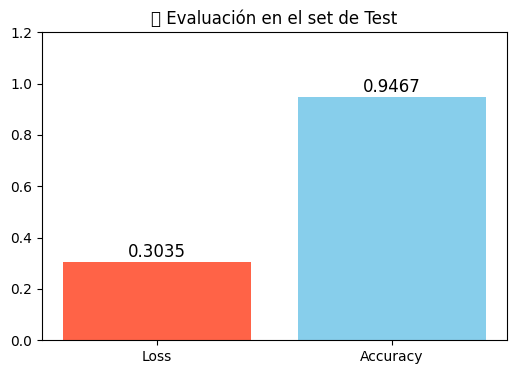

In [ ]:
import matplotlib.pyplot as plt

# Evaluación
loss, acc = model.evaluate(test_generator)

# Redondeo más significativo
loss_rounded = round(loss, 4)  # Redondear loss a 4 decimales
acc_rounded = round(acc, 4)    # Redondear accuracy a 4 decimales

# Gráfico
plt.figure(figsize=(6, 4))
plt.bar(['Loss', 'Accuracy'], [loss_rounded, acc_rounded], color=['tomato', 'skyblue'])
plt.title('📊 Evaluación en el set de Test')
plt.ylim(0, 1.2)  # Ajustá según los valores
for i, v in enumerate([loss_rounded, acc_rounded]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12)  # Mostrar con 4 decimales

plt.show()


In [ ]:

# Obtener imágenes y etiquetas verdaderas desde el generador
x_test, y_true = next(test_generator)
for _ in range(len(test_generator) - 1):
    x_batch, y_batch = next(test_generator)
    x_test = np.concatenate((x_test, x_batch))
    y_true = np.concatenate((y_true, y_batch))

# Obtener predicciones
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Nombres de clases
class_names = list(test_generator.class_indices.keys())

# Encuentra índices correctos e incorrectos
correct_idx = np.where(y_pred == y_true_labels)[0]
incorrect_idx = np.where(y_pred != y_true_labels)[0]

# Función para mostrar imágenes
def show_images(indices, title, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_test[idx])
        true_label = class_names[y_true_labels[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f'Pred: {pred_label}\nReal: {true_label}', color='green' if pred_label == true_label else 'red')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Mostrar imágenes clasificadas correctamente
show_images(correct_idx, '✅ Clasificadas Correctamente')

# Mostrar imágenes clasificadas incorrectamente
show_images(incorrect_idx, '❌ Clasificadas Incorrectamente')


Output hidden; open in https://colab.research.google.com to view.

# **Randome model** **analysis**
lo que hacemos aqui es tomar el modelo y meterlo en un for loop y usamos random para que los valores sean aleatorios justamente, vamos a ir almacenando los resultados y luego podremos visualizar que parametros son los que nos dan los mejores resultados para este modelo

In [ ]:
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from keras.callbacks import ModelCheckpoint
import os
import pandas as pd
from datetime import datetime
from sklearn.metrics import classification_report
import numpy as np

# Directorios de datos
train_dir = '/content/drive/MyDrive/Train'
val_dir = '/content/drive/MyDrive/Validation'
test_dir = '/content/drive/MyDrive/Test'

for i in range(3):  # Cantidad de variantes
    print(f"\n🔁 Iteración {i+1}/3")

    # Hiperparámetros aleatorios
    rotation = random.randint(0, 30)
    zoom = round(random.uniform(0.0, 0.3), 2)
    width_shift = round(random.uniform(0.0, 0.2), 2)
    height_shift = round(random.uniform(0.0, 0.2), 2)
    brightness = [round(random.uniform(0.3, 0.8), 2), round(random.uniform(1.0, 1.5), 2)]
    shear = round(random.uniform(0.0, 0.3), 2)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation,
        zoom_range=zoom,
        width_shift_range=width_shift,
        height_shift_range=height_shift,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=brightness,
        shear_range=shear,
        fill_mode='nearest'
    )

    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
    )

    val_generator = test_val_datagen.flow_from_directory(
        val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
    )

    test_generator = test_val_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
    )

    # Modelo
    input_layer = Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(train_generator.num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Checkpoints
    checkpoint_dir = '/content/drive/MyDrive/Model_Checkpoints/'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, f'best_model_iter_{i+1}.h5'),
        monitor='val_loss', save_best_only=True, mode='min', verbose=1
    )

    # Entrenar
    history = model.fit(
        train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint_callback]
    )

    # Evaluación
    test_generator.reset()
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    train_loss = history.history['loss'][-1]
    train_accuracy = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']

    # Parámetros del generador
    gen_params = {
        "rotation_range": train_datagen.rotation_range,
        "zoom_range": train_datagen.zoom_range,
        "width_shift_range": train_datagen.width_shift_range,
        "height_shift_range": train_datagen.height_shift_range,
        "horizontal_flip": train_datagen.horizontal_flip,
        "vertical_flip": train_datagen.vertical_flip,
        "brightness_range": train_datagen.brightness_range,
        "shear_range": train_datagen.shear_range,
        "fill_mode": train_datagen.fill_mode,
    }

    # Parámetros del modelo
    layer_params = {}
    for j, layer in enumerate(model.layers):
        if isinstance(layer, layers.Conv2D):
            layer_params[f"Conv2D_{j+1}_filters"] = layer.filters
            layer_params[f"Conv2D_{j+1}_kernel"] = layer.kernel_size
            layer_params[f"Conv2D_{j+1}_activation"] = layer.activation.__name__
        elif isinstance(layer, layers.MaxPooling2D):
            layer_params[f"MaxPooling2D_{j+1}_pool_size"] = layer.pool_size
        elif isinstance(layer, layers.Dense):
            layer_params[f"Dense_{j+1}_units"] = layer.units
            layer_params[f"Dense_{j+1}_activation"] = layer.activation.__name__
        elif isinstance(layer, layers.Dropout):
            layer_params[f"Dropout_{j+1}_rate"] = layer.rate

    # Entrada para el log
    entrada = {
        "iteracion": i + 1,
        "fecha": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "train_accuracy": train_accuracy,
        "train_loss": train_loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "weighted_f1": weighted_f1,
        "clases": str(train_generator.class_indices)
    }
    entrada.update(gen_params)
    entrada.update(layer_params)

    # Guardar CSV
    csv_path = "/content/drive/MyDrive/resgistros.csv"
    df = pd.DataFrame([entrada])
    if os.path.exists(csv_path):
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, index=False)

    print("✅ Registro completo guardado con parámetros, métricas y resultados.")



🔁 Iteración 1/3
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3889 - loss: 1.6504
Epoch 1: val_loss improved from inf to 1.33467, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.3907 - loss: 1.6400 - val_accuracy: 0.4500 - val_loss: 1.3347
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5478 - loss: 0.9358
Epoch 2: val_loss improved from 1.33467 to 0.79000, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.5495 - loss: 0.9327 - val_accuracy: 0.6500 - val_loss: 0.7900
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7087 - loss: 0.6569
Epoch 3: val_loss improved from 0.79000 to 0.76828, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7089 - loss: 0.6565 - val_accuracy: 0.7000 - val_loss: 0.7683
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7353 - loss: 0.6202
Epoch 4: val_loss improved from 0.76828 to 0.60781, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.7356 - loss: 0.6200 - val_accuracy: 0.7833 - val_loss: 0.6078
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7688 - loss: 0.5664
Epoch 5: val_loss improved from 0.60781 to 0.52801, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.7688 - loss: 0.5662 - val_accuracy: 0.8333 - val_loss: 0.5280
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7648 - loss: 0.5090
Epoch 6: val_loss did not improve from 0.52801
42/42 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7651 - loss: 0.5090 - val_accuracy: 0.8167 - val_loss: 0.5446
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8132 - loss: 0.4684
Epoch 7: val_loss did not improve from 0.52801
42/42 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8132 - loss: 0.4685 - val_accuracy: 0.7667 - val_loss: 0.5600
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8344 - loss: 0.4446
Epoch 8: val_loss did not improve from 0.52801
42/42 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.8345 - loss: 0.4442 - val_accuracy: 0.8333 - val_loss: 0.5336
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8270 - loss: 0.4546
Epoch 9: val_loss improved from 0.52801 to 0.51752, saving mode

42/42 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8274 - loss: 0.4537 - val_accuracy: 0.8000 - val_loss: 0.5175
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8577 - loss: 0.3530
Epoch 10: val_loss did not improve from 0.51752
42/42 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.8580 - loss: 0.3528 - val_accuracy: 0.8167 - val_loss: 0.5610
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
✅ Registro completo guardado con parámetros, métricas y resultados.

🔁 Iteración 2/3
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3448 - loss: 1.6345
Epoch 1: val_loss improved from inf to 1.03838, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.3449 - loss: 1.6264 - val_accuracy: 0.3167 - val_loss: 1.0384
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5292 - loss: 0.9250
Epoch 2: val_loss improved from 1.03838 to 0.82875, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.5300 - loss: 0.9243 - val_accuracy: 0.5667 - val_loss: 0.8288
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6726 - loss: 0.7638
Epoch 3: val_loss improved from 0.82875 to 0.69140, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.6734 - loss: 0.7620 - val_accuracy: 0.6333 - val_loss: 0.6914
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7081 - loss: 0.6361
Epoch 4: val_loss improved from 0.69140 to 0.65328, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.7090 - loss: 0.6355 - val_accuracy: 0.7500 - val_loss: 0.6533
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7797 - loss: 0.5565
Epoch 5: val_loss improved from 0.65328 to 0.52291, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7801 - loss: 0.5561 - val_accuracy: 0.8000 - val_loss: 0.5229
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8381 - loss: 0.4157
Epoch 6: val_loss improved from 0.52291 to 0.52111, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.8382 - loss: 0.4160 - val_accuracy: 0.7833 - val_loss: 0.5211
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8640 - loss: 0.3428
Epoch 7: val_loss did not improve from 0.52111
42/42 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8640 - loss: 0.3433 - val_accuracy: 0.8500 - val_loss: 0.5604
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8607 - loss: 0.3521
Epoch 8: val_loss improved from 0.52111 to 0.45186, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.8605 - loss: 0.3527 - val_accuracy: 0.8667 - val_loss: 0.4519
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8856 - loss: 0.3113
Epoch 9: val_loss did not improve from 0.45186
42/42 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.8852 - loss: 0.3120 - val_accuracy: 0.8167 - val_loss: 0.4543
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8894 - loss: 0.3135
Epoch 10: val_loss did not improve from 0.45186
42/42 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.8893 - loss: 0.3137 - val_accuracy: 0.8000 - val_loss: 0.4730
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
✅ Registro completo guardado con parámetros, métricas y resultados.

🔁 Iteración 3/3
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3602 - loss: 1.6438
Epoch 1: val_loss improved from inf to 0.82650, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.3623 - loss: 1.6337 - val_accuracy: 0.5833 - val_loss: 0.8265
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6981 - loss: 0.7104
Epoch 2: val_loss improved from 0.82650 to 0.60611, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.6985 - loss: 0.7092 - val_accuracy: 0.7167 - val_loss: 0.6061
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7694 - loss: 0.5282
Epoch 3: val_loss improved from 0.60611 to 0.52606, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7698 - loss: 0.5281 - val_accuracy: 0.8000 - val_loss: 0.5261
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7945 - loss: 0.5143
Epoch 4: val_loss did not improve from 0.52606
42/42 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.7950 - loss: 0.5135 - val_accuracy: 0.7500 - val_loss: 0.6840
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8504 - loss: 0.4466
Epoch 5: val_loss did not improve from 0.52606
42/42 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.8503 - loss: 0.4461 - val_accuracy: 0.7833 - val_loss: 0.6256
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8641 - loss: 0.3706
Epoch 6: val_loss did not improve from 0.52606
42/42 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8637 - loss: 0.3715 - val_accuracy: 0.7833 - val_loss: 0.5320
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8730 - loss: 0.3934
Epoch 7: val_loss did not improve from 0.52606
42/42 ━━━━━━━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8693 - loss: 0.3600 - val_accuracy: 0.8500 - val_loss: 0.4790
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8960 - loss: 0.3352
Epoch 9: val_loss improved from 0.47902 to 0.34733, saving model to /content/drive/MyDrive/Model_Checkpoints/best_model_iter_3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.8960 - loss: 0.3351 - val_accuracy: 0.8667 - val_loss: 0.3473
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9018 - loss: 0.2953
Epoch 10: val_loss did not improve from 0.34733
42/42 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9016 - loss: 0.2956 - val_accuracy: 0.8167 - val_loss: 0.4899
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
✅ Registro completo guardado con parámetros, métricas y resultados.


In [ ]:
import pandas as pd
import os
from datetime import datetime
from sklearn.metrics import classification_report
import numpy as np

# Ruta del CSV
csv_path = "/content/drive/MyDrive/resgistros.csv"

# 🔹 Evaluar modelo (accuracy y loss)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# 🔹 Obtener métricas del classification_report
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# 🔹 Promedios macro y weighted (para resumen general)
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']

weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']

# 🔹 Parámetros del ImageDataGenerator
gen_params = {
    "rotation_range": train_datagen.rotation_range,
    "zoom_range": train_datagen.zoom_range,
    "width_shift_range": train_datagen.width_shift_range,
    "height_shift_range": train_datagen.height_shift_range,
    "horizontal_flip": train_datagen.horizontal_flip,
    "vertical_flip": train_datagen.vertical_flip,
    "brightness_range": train_datagen.brightness_range,
    "shear_range": train_datagen.shear_range,
    "fill_mode": train_datagen.fill_mode,
}

# 🔹 Extraer parámetros de las capas
layer_params = {}
for i, layer in enumerate(model.layers):
    if isinstance(layer, layers.Conv2D):
        layer_params[f"Conv2D_{i+1}_filters"] = layer.filters
        layer_params[f"Conv2D_{i+1}_kernel"] = layer.kernel_size
        layer_params[f"Conv2D_{i+1}_activation"] = layer.activation.__name__
    elif isinstance(layer, layers.MaxPooling2D):
        layer_params[f"MaxPooling2D_{i+1}_pool_size"] = layer.pool_size
    elif isinstance(layer, layers.Dense):
        layer_params[f"Dense_{i+1}_units"] = layer.units
        layer_params[f"Dense_{i+1}_activation"] = layer.activation.__name__
    elif isinstance(layer, layers.Dropout):
        layer_params[f"Dropout_{i+1}_rate"] = layer.rate

# 🔹 Armar entrada de log
entrada = {
    "fecha": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "train_accuracy": train_accuracy,
    "train_loss": train_loss,
    "val_accuracy": val_accuracy,
    "val_loss": val_loss,
    "test_accuracy": test_accuracy,
    "test_loss": test_loss,
    "macro_precision": macro_precision,
    "macro_recall": macro_recall,
    "macro_f1": macro_f1,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}
entrada.update(gen_params)
entrada.update(layer_params)

# 🔹 Guardar
df = pd.DataFrame([entrada])
if os.path.exists(csv_path):
    df.to_csv(csv_path, mode='a', header=False, index=False)
else:
    df.to_csv(csv_path, index=False)

print("✅ Registro completo guardado con parámetros, métricas y resultados.")


✅ Registro guardado con parámetros del modelo y resultados.
